# Wstęp do uczenia maszynowego
##  Projekt nr 2
#### Jakub Piwko, Malwina Wojewoda

# CO UDAŁO MI SIĘ ZROBIĆ

* Wywaliłem od razu zmienną caseid
* Sprawdziłem korelacje, było trochę większych, więc wywaliłem wszytskie których moduł przekraczał 0.7. Wypadło aż 30 kolumn, może za dużo?
* histogramy do rozkładów pozostałych zmiennych
* Jakieś badziewne wykresy bąbelkowe, które pokazują liczności w przecięciach zmiennych xD Nie mam na nic więcej pomysłu. 
* Skalowanie do [0,1], żeby łatwiej potem się pracowało - kontrowersyjne
* Metoda łockcia do szukania licczby klastrów
* Pierwsze modele KMeans
* Zrobiłem też funkcję, która tworzy wykres punktowy pokazujący centroidy poszczególnych kolumn dla poszczególnych klastrów co ma zastępować te wykresy 2D, wydał mi się fajny i zrozumiały, ale może uda się znaleźć coś lepszego, co lepiej wizualizuje podział klastrów

#### Pakiety

In [63]:
import pandas as pd
#import numpy as np
#from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

### Wczytanie danych oraz ich opis

Jak dowiadujemy się z opisu danych są one obrobioną nieco wersją zbioru USCensus1990raw. Zawierał  on 1 % próbki z pełnego spisu powszechnego z 1990r. W naszym pliku rekordy zostały losowo przemieszane. Aby uzyskać zbiór, którym się zajmujemy zostały wykonane następujące operacje: 
* randomizacja: rekordy z USCensus1990raw zostały losowo permutowane
* zmiany w kolumnach: kilka zmiennych ciągłych zostało zdyskretyzowane, a zmienne dyskretne, które miały dużo wartości zostało zwinięte do mniejszej liczby wartości; kolumny, które nie uległy zmianie oznaczone są prefiksem "i", a te które były zmienione - prefiksem "d"; dokładne zmieny zostały opisane w pliku *USCensus1990.mapping.sql*
* usunięto kolumny, które były mało przydatne

Można więc powiedzieć, że na danych został już wykonany preprocessing.

Pierwszym atrybutem jest caseid i powinnien on być ignorowany podczas analizy.  
Wszystkie dane są numeryczne.

In [3]:
X = pd.read_csv('USCensus1990.data.txt')
X.head()

,caseid,dAge,dAncstry1,dAncstry2,iAvail,iCitizen,iClass,dDepart,iDisabl1,iDisabl2,...,iTmpabsnt,dTravtime,iVietnam,dWeek89,iWork89,iWorklwk,iWWII,iYearsch,iYearwrk,dYrsserv
0,10000,5,0,1,0,0,5,3,2,2,...,0,5,0,2,1,1,0,11,1,0
1,10001,6,1,1,0,0,7,5,2,2,...,0,1,0,2,1,1,0,5,1,0
2,10002,3,1,2,0,0,7,4,2,2,...,0,2,0,2,1,1,0,10,1,0
3,10003,4,1,2,0,0,1,3,2,2,...,0,1,0,1,1,1,0,10,1,0
4,10004,7,1,1,0,0,0,0,2,2,...,3,0,0,0,2,2,0,5,6,0


In [4]:
X.shape

(2458285, 69)

Sprawdźmy czy w zbiorze są jakieś braki danych:

In [5]:
X.isna().sum().sum()

0

In [6]:
X.isnull().sum().sum()

0

Wygląda na to, że w naszym zbiorze nie ma braków danych.

In [7]:
X.duplicated().sum()

0

Nie ma też zduplikowanych wierszy.

# takie coś jest w task descr ale nigdzie nei mogłam tego znalezc, poza tym to z 2001 wiec chyba nei ma sensu o tym myśleć, jakbyś też wpadł na taki głupi pomysł

Meek, Thiesson, and Heckerman (2001) provide a method for selecting the number of points to use during the construction of a clustering model and demonstrate the method can lead to substantial speedups while obtaining clusters with comparable predictive power. Their analysis is performed on several data sets including the USCensus1990 data set.

Meek, Thiesson, and Heckerman (2001), "The Learning Curve Method Applied to Clustering", to appear in The Journal of Machine Learning Research. (Also see MSR-TR-2001-34




Sprawdzimy jeszcze jakie są unikalne wartości w każdej z kolumn:

In [7]:
pd.set_option('display.max_rows', None) 
print(X.apply(lambda col: col.unique()))

caseid       [10000, 10001, 10002, 10003, 10004, 10005, 100...
dAge                                  [5, 6, 3, 4, 7, 1, 2, 0]
dAncstry1               [0, 1, 11, 3, 2, 9, 8, 10, 4, 6, 7, 5]
dAncstry2              [1, 2, 12, 3, 4, 10, 7, 5, 11, 8, 6, 9]
iAvail                                         [0, 3, 4, 2, 1]
iCitizen                                       [0, 3, 4, 2, 1]
iClass                          [5, 7, 1, 0, 6, 3, 4, 2, 8, 9]
dDepart                                     [3, 5, 4, 0, 2, 1]
iDisabl1                                             [2, 0, 1]
iDisabl2                                             [2, 0, 1]
iEnglish                                       [1, 0, 2, 3, 4]
iFeb55                                                  [0, 1]
iFertil         [1, 3, 0, 4, 7, 2, 5, 6, 12, 8, 13, 10, 9, 11]
dHispanic                       [0, 1, 9, 2, 6, 3, 4, 8, 7, 5]
dHour89                                     [4, 1, 3, 0, 5, 2]
dHours                                      [3, 1, 4, 0

In [8]:
pd.set_option('display.max_rows', 10) #back to default

Oryginalny zbiór jest duży, ograniczymy go do losowej jednoprocentowej próbki, dodatkowo usuniemy zmienną caseid.

In [8]:
df = X.sample(frac=0.01, random_state=42)
df.drop('caseid', inplace = True, axis = 1)

In [10]:
df.shape

(24583, 68)

### Analiza zmiennych

Przejdziemy teraz do głębszej analizy zmiennych zawartych w naszej ramce. Przyjrzymy sie mapie korelacji a także zależnościom między zmiennymi. 

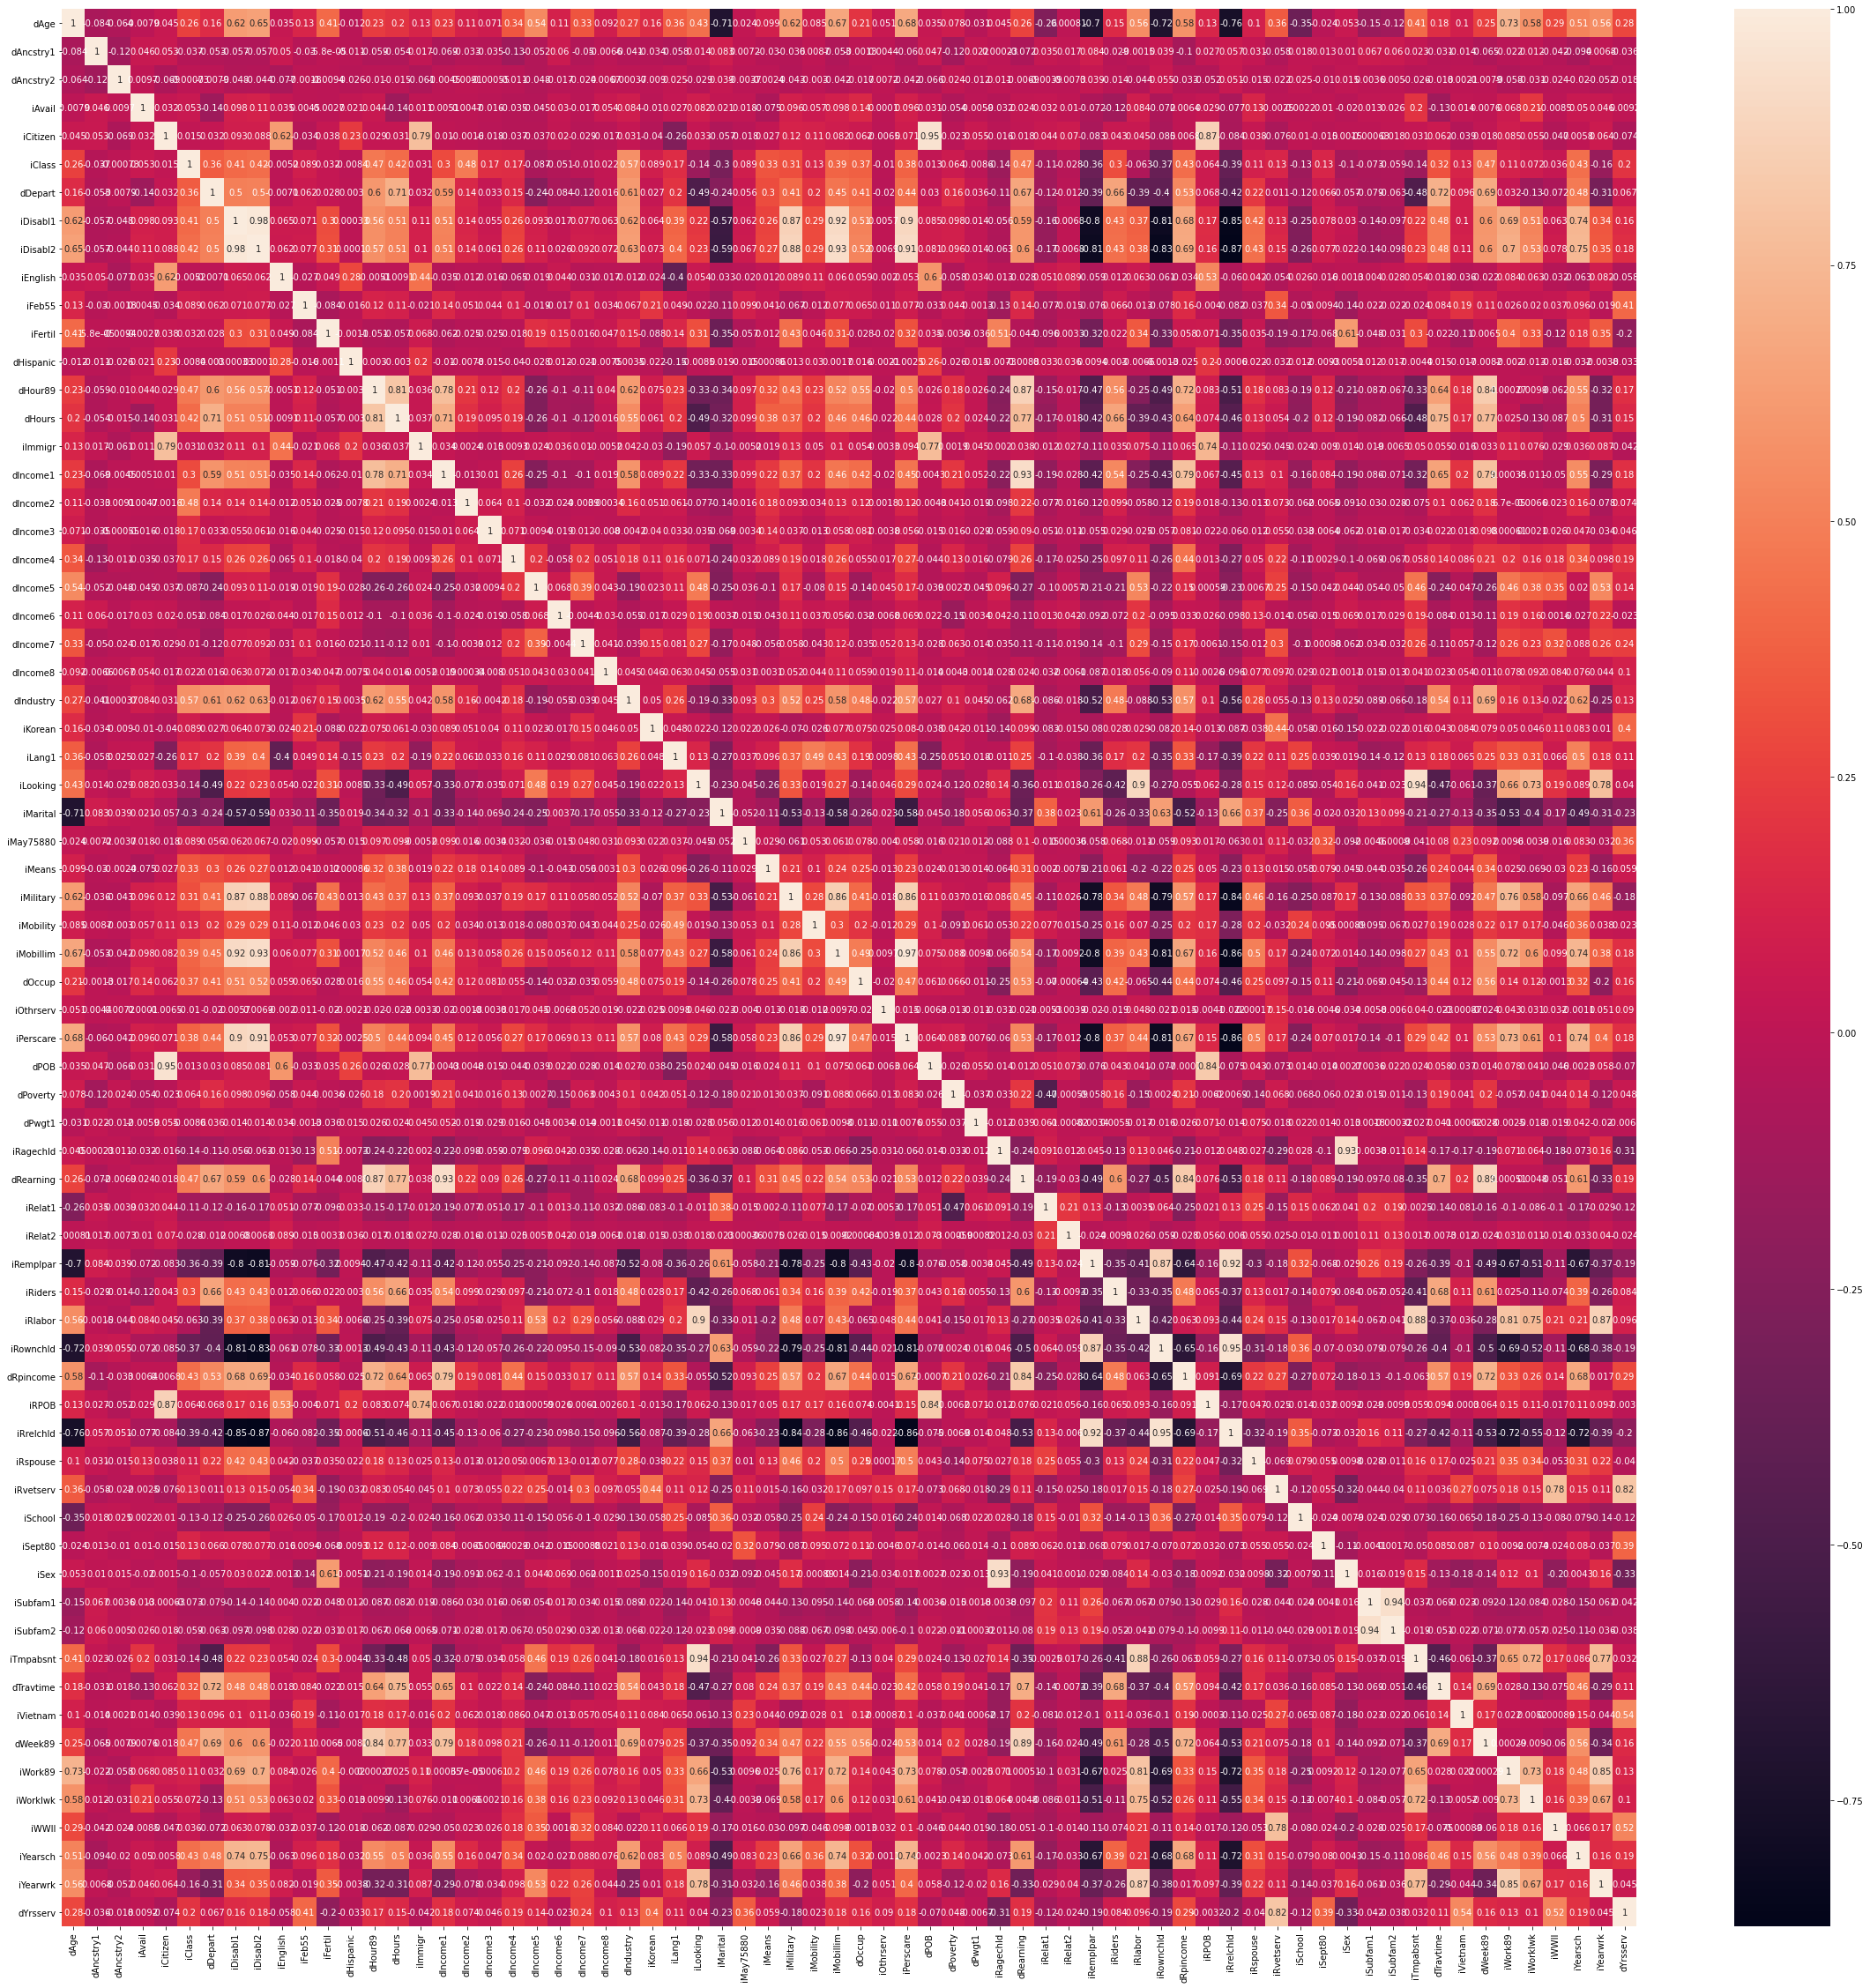

In [11]:
plt.figure(figsize=(40, 40))
sns.heatmap(df.corr(method = 'pearson'), annot=True)
plt.show()

Z powyższej mapy możemy odczytać, że w ramce danych występują wysoko skorelowane zmienne. Podzbędziemy się tych o najwyższym modle wartości korelacji. 

In [9]:
correlated_features = set()
corr = df.corr(method = 'spearman')
for i in range(len(corr .columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) >= 0.70:
            colname = corr.columns[i]
            correlated_features.add(colname)

In [10]:
print(len(correlated_features))
print(correlated_features)

30
{'iSubfam2', 'dHour89', 'iRrelchld', 'iRownchld', 'iPerscare', 'iRiders', 'iDisabl2', 'dRearning', 'dTravtime', 'iWork89', 'iYearsch', 'dPOB', 'dHours', 'iMilitary', 'iSex', 'dWeek89', 'iImmigr', 'dIndustry', 'iMobillim', 'iYearwrk', 'iRlabor', 'iRemplpar', 'dIncome1', 'iRspouse', 'iMeans', 'iWorklwk', 'iTmpabsnt', 'dYrsserv', 'dOccup', 'dRpincome'}


In [11]:
df.drop(labels=correlated_features, axis=1, inplace=True)
df.shape

(24583, 38)

Po obróbce zostało 38 kolumn w ramce. Jako, że wszystkie z nich są kategoryczne, zbadamy teraz ich rozkłady na grupowym histogramie.

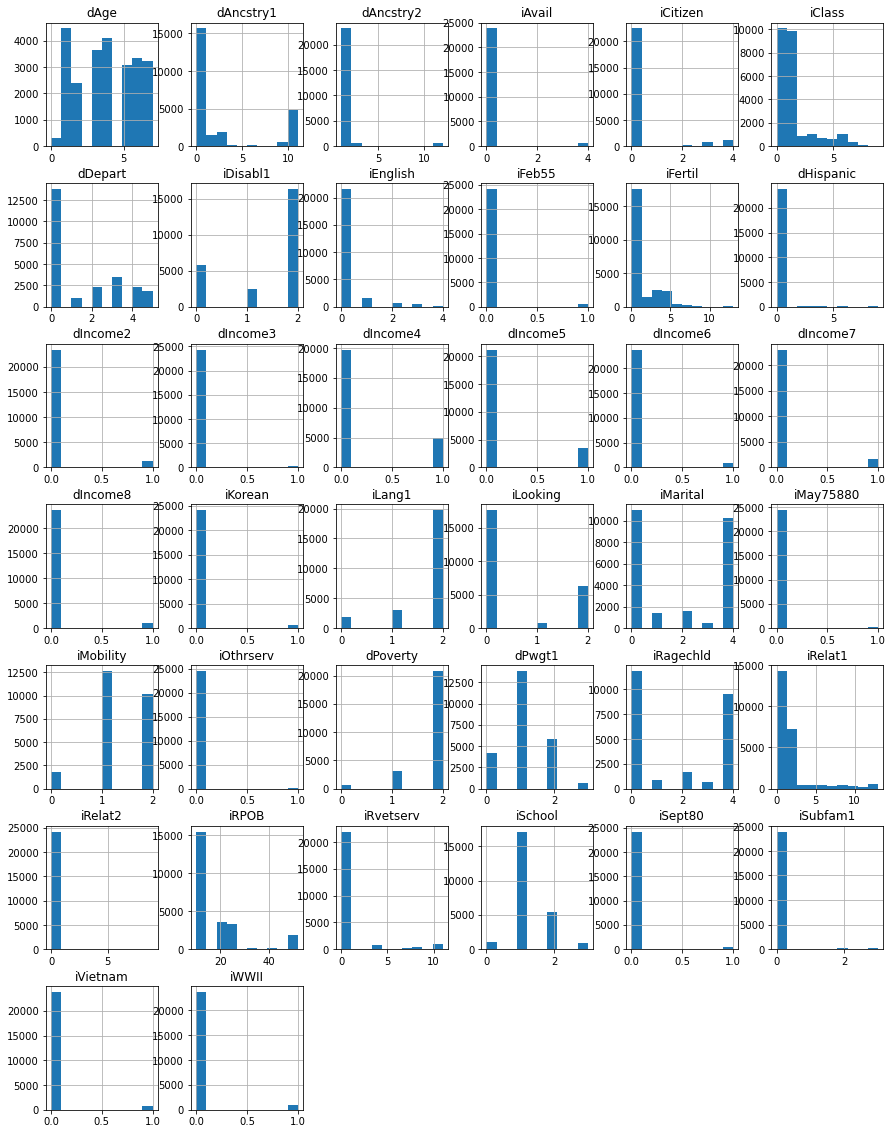

In [21]:
df.hist(figsize=(15,20))
plt.show()

Możemy zauważyć, że większość zmiennych ma bardzo nierównomierny rozkład, w którym przeważa jedna lub dwie wartości. Jednynie zmienna `dAge` przypomina rozkład jednostajny. 


Następnie przyjrzemy się wykresom wizualizującym relacje między zmiennymi, aby odkryć jakieś zależności, które mogą nam pomóc przy doborze klastrów. Przyjrzemy się bubble plotom, które pokazują liczności przecięć dwóch zmiennych.

In [12]:
def HeatMap(column1, column2):
    df1 = df.groupby([column1, column2]).size().reset_index(name='counts')
    df1 = pd.pivot(df1, index = 'race', columns = 'sex', values = 'counts')
    sns.heatmap(df1, annot=True, cmap='Reds', ax=ax1, fmt='g', norm=LogNorm())
    
def BubblePlot(column1, column2):
    df1 = df.groupby([column1, column2]).size().reset_index(name='counts')
    plt.figure(figsize = (12, 8))
    plt.scatter(df1[column1], df1[column2], s=df1['counts'], alpha = 0.7)
    plt.xlabel(column1)
    plt.ylabel(column2)

In [30]:
df1 = df.groupby(['iMarital', 'iClass']).size().reset_index(name='counts')

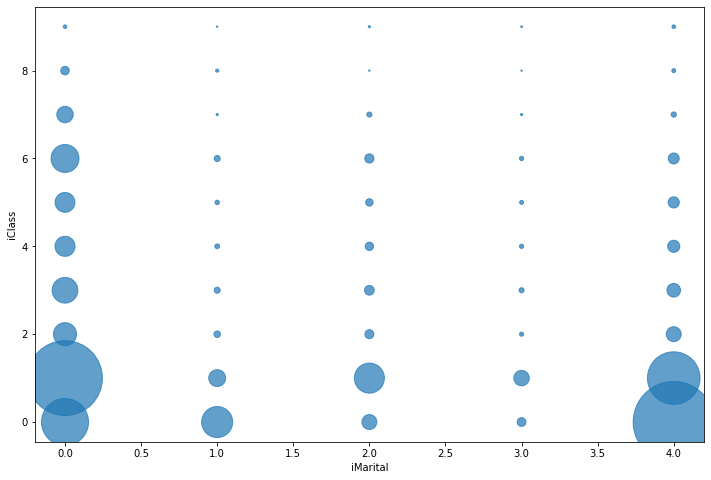

In [45]:
BubblePlot('iMarital', 'iClass')

Widać, że przeważają grupy osób, które są w związku małżeńskim (1 na osi x) nigdy nie były w sformalizowanym związku lub poniiżej 15 roku życia (4 na osi x). Dodatkowo widać, że w grupie 4 na osi x, jest dużo osób, które nigdy nie były zatrudnione lub mają mniej niż 16 lat (0 na osi y), co jest dosyć intuicyjne. Dodatkowo wśród osób zamężnych jest przewaga osób pracujących prywatnie (1 na osi y)

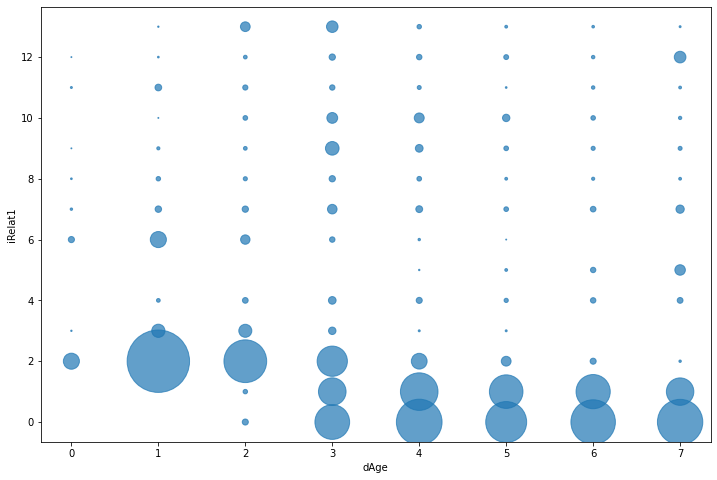

In [46]:
BubblePlot('dAge', "iRelat1")

Na wykresie ze zmiennymi `dAge` i `iRelat1` widać niesamowicie ciekawe i oszałamiające rzeczy. **(NIE WIEM DO KOŃCA JAK INTERPRETOWAĆ ZMIENNĄ iRelat1 BO TAM SĄ WARTOSCI TYPU SYN, MAŻ, LOKATOR ??) A W SUMIE WIEKU TEŻ NIE ROZUMIEM** widać, że starsze osoby (po 2 na osi x) są posiadaczami domów (0 na osi y) i są zakawalifikowani jako mąż lub żona (1 na osi y). Natomiast osoby młodsze (1 na osi x) są kwalifikowani przede wszytskim jako dzieci (NO WOW CO ZA NIESPODZIANKA) Można za to wnioskować może być istotny przy klastrowaniu.

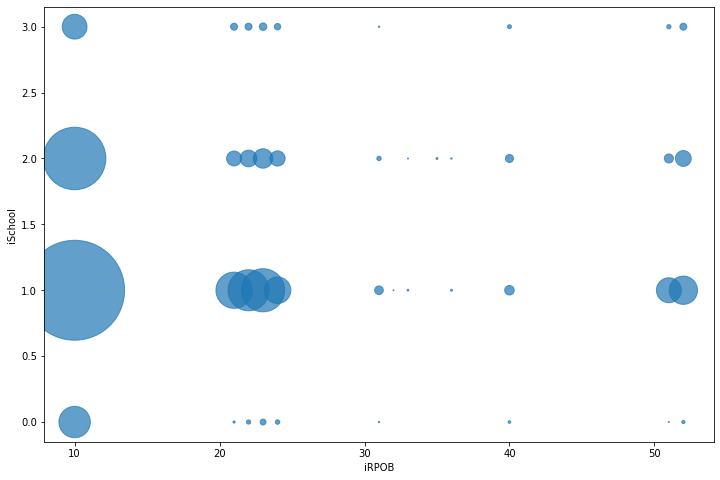

In [14]:
BubblePlot('iRPOB', 'iSchool')


Najwięcej osób nie chodzi do szkoły (1 na osi y), w co wliczają się także dorośli najwyraźniej. Najwięcej soób urodziło się także w stanie, w którym się urodziło. Grupa w okolicach wartości wartośći 20 dla iRPOB to inni urodzeni w Stanach, natomiast wartości po 50 to osoby nie będące obywatelami USA albo zasymilowani/znaturalizowani obywatele.

In [ ]:
#dendrogram
#shillouete 

### Skalowanie

# !!!
Ogólnie uznałem, że może można przeskalować dane do przedziału [0,1], bo potem na wykresie tych centroidów to wygląda lepiej, możesz spróbować bez skalowania i po skalowaniu na 
przykład zeby porównać jak wygląda CentroidsPlot. Chcociaż wydaje mi się, że może to mieć znaczenie przy klastrowaniu...

Aby znormalizować naszą ramkę danych, postanowiliśmy przeskalować dane, aby zawierały się tylko w zbiorze [0,1]. Zmienne nadal pozostaną dyksretne, ale będzie zdecydowanie łatwiej analizować dobierane klastry w późniejszych krokach. Mamy na uwadze również to, że takie skalowanie zmieni dobór klastrów, bo odległości między punktami będą ewaluowane inaczej. 

In [66]:
for col in df.columns:
    min_max_scaler1 = MinMaxScaler()
    scaled_col1 = min_max_scaler1.fit_transform(df[col].values.reshape(-1, 1))
    df[col] = scaled_col1

### Modelowanie

In [68]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster import hierarchy
from sklearn import cluster, datasets, mixture
from sklearn_extra.cluster import KMedoids
from yellowbrick.cluster import SilhouetteVisualizer

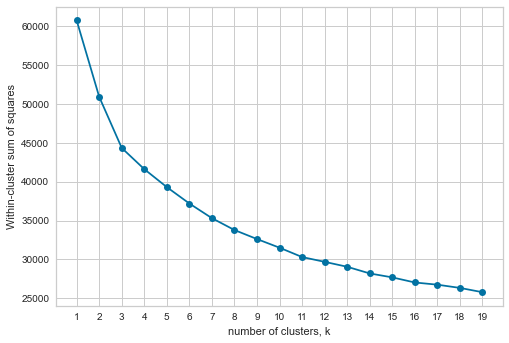

In [69]:
clus_num = range(1, 20)
scores = []

for k in clus_num:
    model = KMeans(n_clusters = k)
    model.fit(df)
    scores.append(model.score(df) * -1)
    
plt.plot(clus_num, scores, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('Within-cluster sum of squares')
plt.xticks(clus_num)
plt.show()

Na początek zbadaliśmy metodą łokcia, jaka liczba klastrów będzie optymalna. Wykres scorów dla liczby klastrów od 1 do 19 jest słabo stromy, więc trudno wybrać jednoznacznie punkt przegięcie. Ustalmy jednak, ze znajduje się on w okolicach wartośći od 5 d 9

Uznaliśmy, ze dobrą metodą na wizualizacje jak model dzieli dane na klastry, jest wykorzystanie centroidów i porównywanie ich w zależności od klastra dla każdej ze zmiennych.

In [95]:
def CentroidsPlot(centroids):
    cent_df = pd.DataFrame(columns= ['cluster', 'variable', 'centroid'])
    rows = centroids.shape[0]
    clusters = [x+1 for x in range(rows)]
    for colname in centroids.columns:
        data = {'cluster' : clusters,
               'variable' : [colname for x in range(rows)],
               'centroid' : centroids[colname]}
        cent_df = pd.concat([cent_df, pd.DataFrame(data)])
    plt.figure(figsize=(18, 8))
    scatter = plt.scatter(cent_df.variable, cent_df.centroid, c=cent_df.cluster, cmap='viridis', s = 200, alpha = 0.7)
    plt.legend(handles=scatter.legend_elements()[0], 
           labels=clusters,
           title="cluster")
    plt.xticks(rotation = 90, fontsize = 15)

#### KMeans
Na początek zbudujemy modele KMeans dla znalezionych wcześniej optymalnych liczb klastrów

In [72]:
model = KMeans(n_clusters = 5)
model.fit(df)
labs = model.labels_
centroids = model.cluster_centers_
centroids = pd.DataFrame(columns = df.columns, data = centroids)

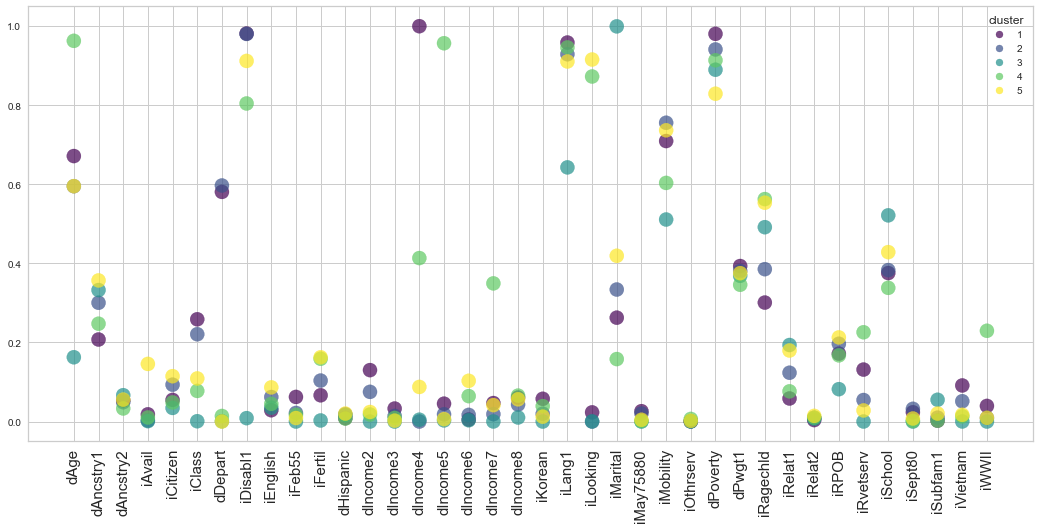

In [96]:
CentroidsPlot(centroids)

In [97]:
model = KMeans(n_clusters = 7)
model.fit(df)
labs = model.labels_
centroids = model.cluster_centers_
centroids = pd.DataFrame(columns = df.columns, data = centroids)

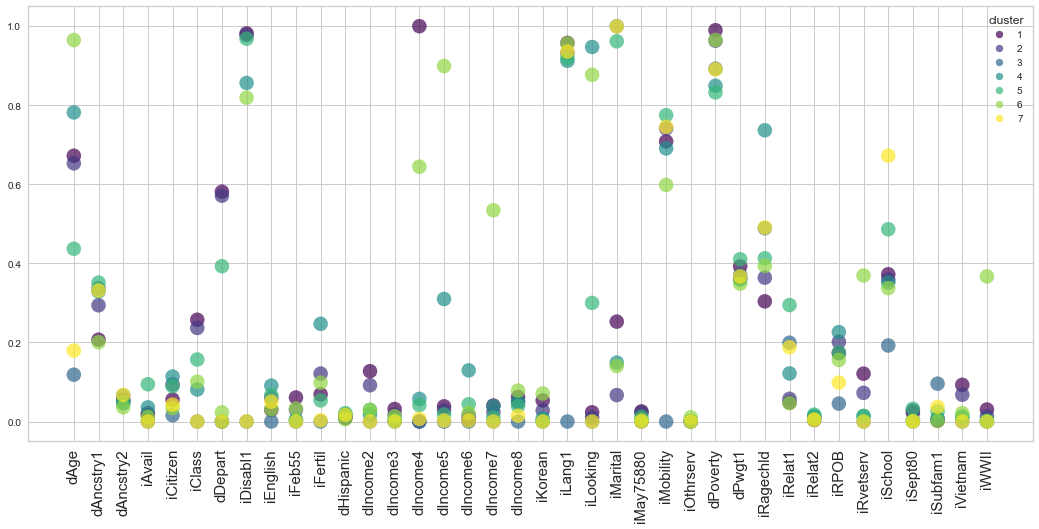

In [98]:
CentroidsPlot(centroids)

In [99]:
model = KMeans(n_clusters = 9)
model.fit(df)
labs = model.labels_
centroids = model.cluster_centers_
centroids = pd.DataFrame(columns = df.columns, data = centroids)

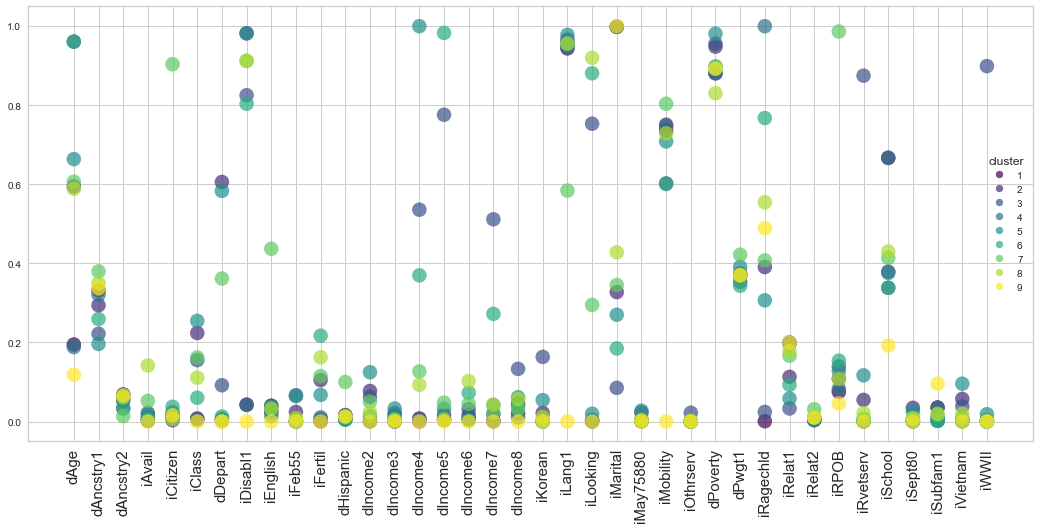

In [100]:
CentroidsPlot(centroids)

Widać, że dobór większej liczby klastrów sprawia problemy, ponieważ kolejne klastry są do siebie za bardzo zbliżone. Dla 5 klastrów widać, że grupy mają różne dobrane centroidy, przez co wydaje się, że rzeczywiście dobrze rozdzielają rekory na różne klastry. Na pewno widać, że klaster oznaczony jako 3 dobrze oddziela młodzież i dzieci, natomiast klaster 4 ludzi starszych.